Import needed stuff

In [1]:
import requests
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
from matplotlib import pyplot as plt
import seaborn as sns
import networkscience as ns
import pycountry as pc

Downloading data by http request

In [2]:
# reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
# reply.encoding = 'utf-8'
# csv_data = reply.text
# df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False)
country_df = pd.read_csv('erasmus_data_clean.csv', sep=';',low_memory=False, header=0)

## Mobility of Countries
In this section we want to analyze how musch different countries are involved in the Erasmus program.

I am not sure there are enought node to have a sensible analysis of the problem.

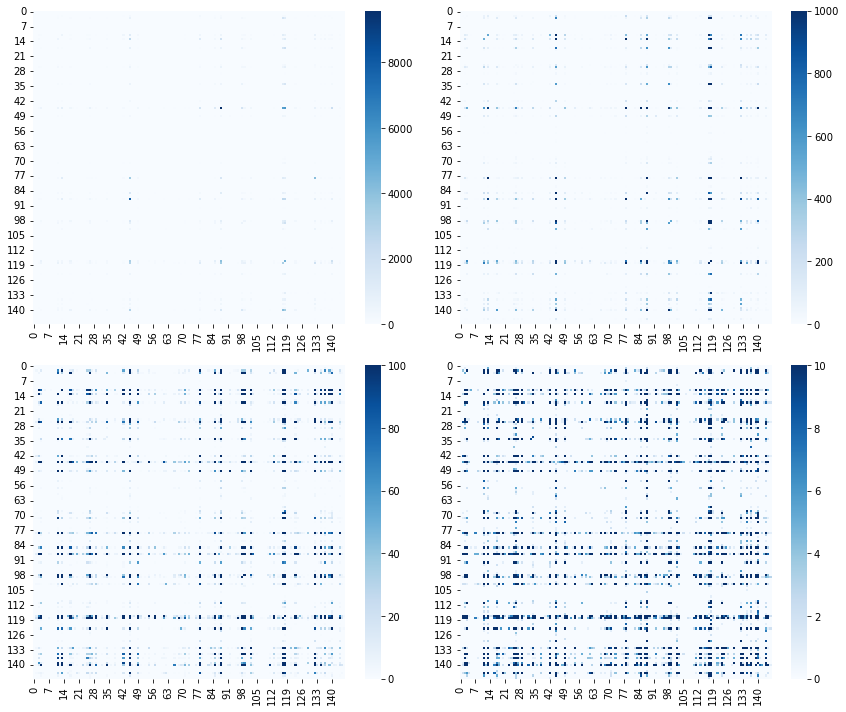

In [3]:
#country_df = df[df[df.columns[10]]=='Learner']
#country_df = country_df.loc[:, df.columns[np.array((14, 17, 20))]]
#country_df.dropna(how='any', inplace=True)
# nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[0]]), set(country_df.loc[:, country_df.columns[1]]))))
nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[4]]), set(country_df.loc[:, country_df.columns[5]]))))
country_df.dropna(how='any', inplace=True)
# I don't want it to take forever
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
country_df['SendId'] = (np.array(list(map(lambda x: node_position[x], country_df['Sending Country Code']))))
country_df['RecId']= (np.array(list(map(lambda x: node_position[x], country_df['Receiving Country Code']))))
# Adjacency matrix
country_serie = country_df.groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

def replace_iso3166(alpha):
    try:
        return pc.countries.get(alpha_2=alpha).name
    except:
        return alpha

country_df['Receiving Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Receiving Country Code']))))
country_df['Sending Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Sending Country Code']))))
nodes_df['Nodes'] = (np.array(list(map(lambda x: replace_iso3166(x), nodes_df['Nodes']))))

ns.visualize_adj(adj_matrix_crs)

I would like to understand if the corresponent undirected unwiegthed graph was symmetric, but it is not

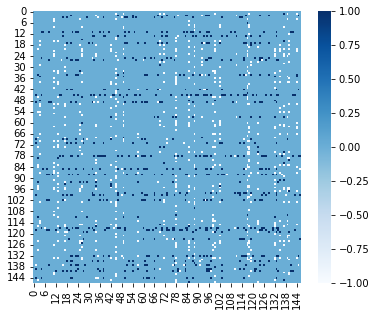

In [4]:
matr = adj_matrix_crs.toarray()
matr[matr>1]=1
matr = matr - matr.T
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(matr, cmap="Blues", ax=ax)
plt.show()


Calculation of the number of components in the network

In [5]:
country_df.rename({'Sending Country Code': 'source', 'Receiving Country Code':'target', 'Participants':'weight'},axis=1, inplace=True)
components = ns.find_components(adj_matrix_crs, nodes_df)
unique, counts = np.unique(components['component'], return_counts=True)
print('Number of components =', len(unique))

Number of components = 2


### Degree distribution

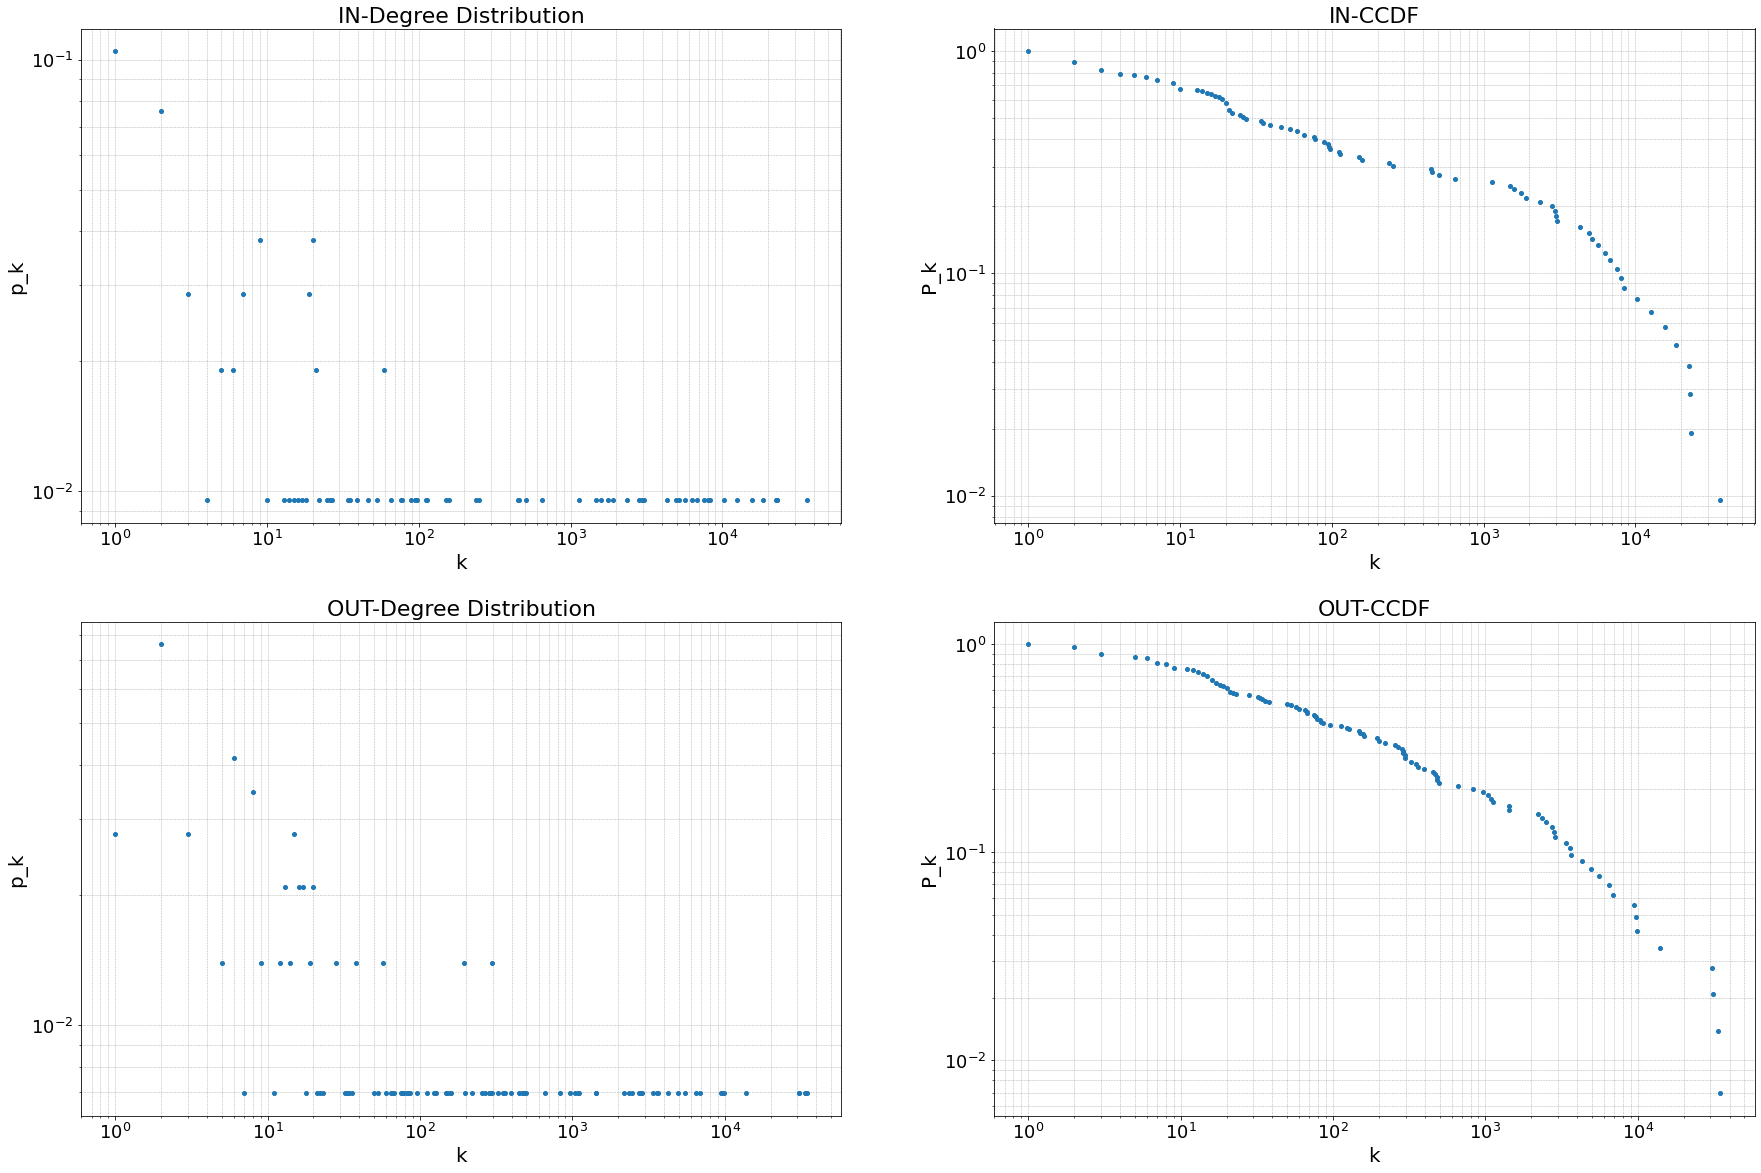

Top 10 for in degree


,Nodes,in degree
45,Spain,36061
117,France,23076
118,Germany,22881
88,Italy,22656
140,UK,18489
78,Poland,15588
13,Portugal,12579
98,Netherlands,10212
11,Czechia,8353
17,Sweden,8069


Top 10 for out degree


,Nodes,out degree
45,Spain,34644
118,Germany,33750
88,Italy,30946
117,France,30586
132,Turkey,13897
98,Netherlands,9824
78,Poland,9781
140,UK,9398
13,Portugal,6864
85,Belgium,6498


In [6]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### HITS (NetworkX)

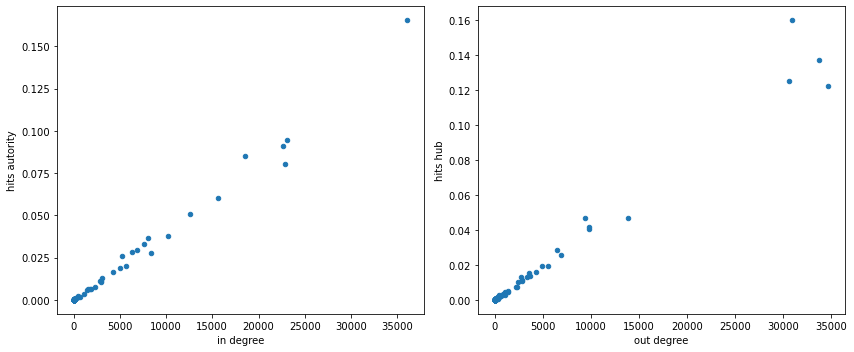

Top 10 for hits hub


,Nodes,hits hub
88,Italy,0.159838
118,Germany,0.137307
117,France,0.124933
45,Spain,0.122427
140,UK,0.046543
132,Turkey,0.046529
98,Netherlands,0.041817
78,Poland,0.040711
85,Belgium,0.028642
13,Portugal,0.025891


Top 10 for hits autority


,Nodes,hits autority
45,Spain,0.165365
117,France,0.094807
88,Italy,0.090851
140,UK,0.085194
118,Germany,0.080147
78,Poland,0.060180
13,Portugal,0.050619
98,Netherlands,0.037963
17,Sweden,0.036765
99,Finland,0.033226


In [7]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

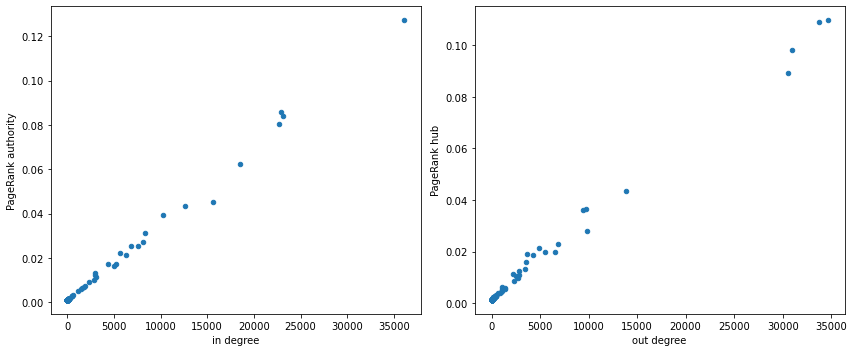

Top 10 for PageRank hub


,Nodes,PageRank hub
45,Spain,0.109555
118,Germany,0.108978
88,Italy,0.097891
117,France,0.089319
132,Turkey,0.043546
78,Poland,0.036413
140,UK,0.036291
98,Netherlands,0.027928
13,Portugal,0.023102
26,Austria,0.021601


Top 10 for PageRank authority


,Nodes,PageRank authority
45,Spain,0.127210
118,Germany,0.086031
117,France,0.084201
88,Italy,0.080548
140,UK,0.062429
78,Poland,0.045424
13,Portugal,0.043197
98,Netherlands,0.039129
11,Czechia,0.031233
17,Sweden,0.027290


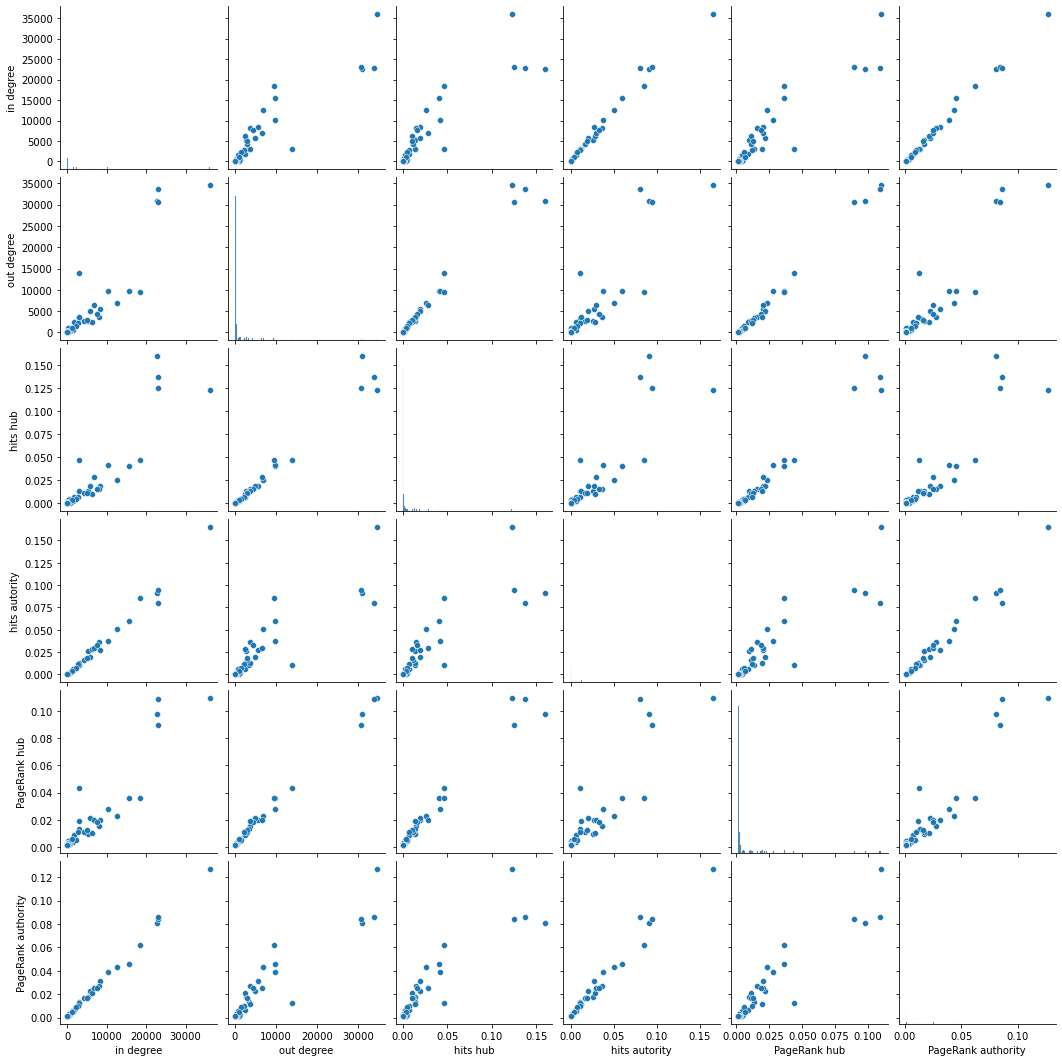

In [8]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank authority')

sns.pairplot(scores)
plt.show()

In [9]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores

scores = create_position(scores, 'in degree')
scores = create_position(scores, 'out degree')
scores = create_position(scores, 'hits hub')
scores = create_position(scores, 'hits autority')
scores = create_position(scores, 'PageRank hub')
scores = create_position(scores, 'PageRank authority')
scores.sort_index(inplace=True)

In [10]:
n = 40
pd.set_option('display.max_rows', n)
display(scores.sort_values('PageRank authority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits autority', 'hits autority position', 'PageRank authority', 'PageRank authority position']].head(n))
display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))

,Nodes,in degree,in degree position,hits autority,hits autority position,PageRank authority,PageRank authority position
45,Spain,36061,1,0.165365,1,0.127210,1
118,Germany,22881,3,0.080147,5,0.086031,2
117,France,23076,2,0.094807,2,0.084201,3
88,Italy,22656,4,0.090851,3,0.080548,4
140,UK,18489,5,0.085194,4,0.062429,5
78,Poland,15588,6,0.060180,6,0.045424,6
13,Portugal,12579,7,0.050619,7,0.043197,7
98,Netherlands,10212,8,0.037963,8,0.039129,8
11,Czechia,8353,9,0.027589,13,0.031233,9
17,Sweden,8069,10,0.036765,9,0.027290,10


,Nodes,out degree,out degree position,hits hub,hits hub position,PageRank hub,PageRank hub position
45,Spain,34644,1,0.122427,4,0.109555,1
118,Germany,33750,2,0.137307,2,0.108978,2
88,Italy,30946,3,0.159838,1,0.097891,3
117,France,30586,4,0.124933,3,0.089319,4
132,Turkey,13897,5,0.046529,6,0.043546,5
78,Poland,9781,7,0.040711,8,0.036413,6
140,UK,9398,8,0.046543,5,0.036291,7
98,Netherlands,9824,6,0.041817,7,0.027928,8
13,Portugal,6864,9,0.025891,10,0.023102,9
26,Austria,4930,12,0.019139,12,0.021601,10


### Assortativity
We have to check if this disassortativity is due to structural reason, because it looks weird. It is almost the opposit of what we saw for the complete network.

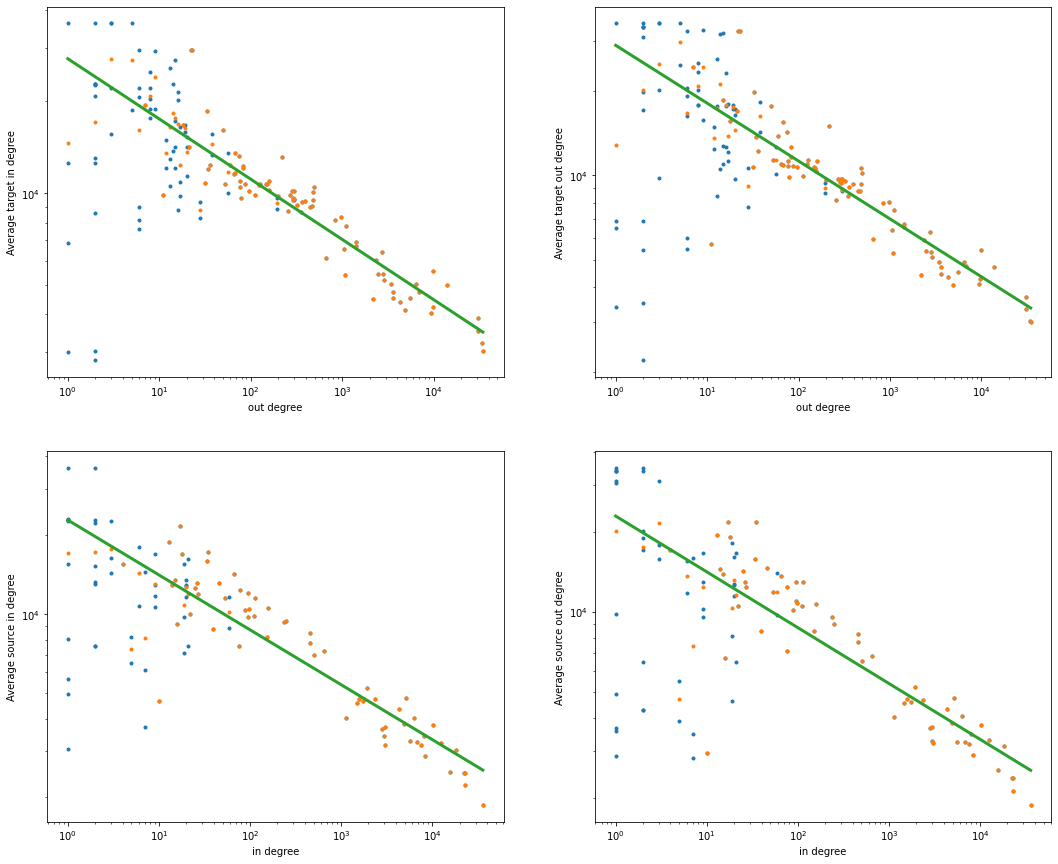

(-0.19762392162556142,
 -0.20560451452382256,
 -0.20933480935164436,
 -0.20970160450386402)

In [11]:
edges = country_df[['source','target']].copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

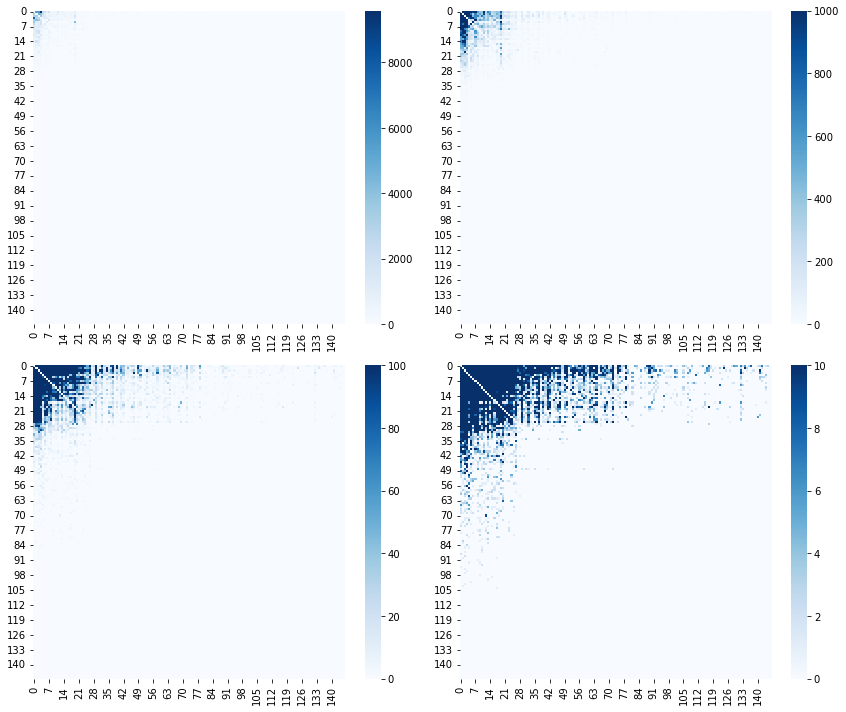

In [12]:
# label = 'PageRank autority position'
label = 'in degree position'
c = country_df.drop(['SendId', 'RecId'],axis=1)
another_order = scores[['Nodes', label]].copy()
another_order[label] = another_order[label] - 1
another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
c = pd.merge(c, another_order, on="source")
another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
c = pd.merge(c, another_order, on="target")
c_serie = c.groupby(['source ID', 'target ID']).sum()
row = np.array(c_serie.index.get_level_values(1).tolist())
col = np.array(c_serie.index.get_level_values(0).tolist())
val = c_serie.values
or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

ns.visualize_adj(or_adj)

The plot highlights differences between the adjacency matrix and the transpose one. It can explain disassortativity.

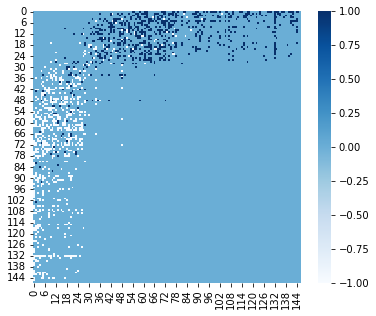

In [13]:
matr = or_adj.toarray()
matr[matr>1]=1
matr = matr - matr.T
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(matr, cmap="Blues", ax=ax)
plt.show()

This is only a draft version of community detection

In [14]:
import networkx as nx
# import community

G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
node_comm = nodes_df.copy()

node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
for i, set in enumerate(p):
    display(node_comm[node_comm['Community']==i])


,Nodes,Community
6,Barbados,0
7,Cameroon,0
10,Mali,0
12,Paraguay,0
14,Iraq,0
...,...,...
130,Angola,0
131,Madagascar,0
134,Pakistan,0
136,Singapore,0


,Nodes,Community
2,Croatia,1
3,Ireland,1
16,Lebanon,1
17,Sweden,1
18,Bosnia and Herzegovina,1
...,...,...
140,UK,1
141,Nigeria,1
143,Myanmar,1
145,Canada,1


,Nodes,Community
5,Nicaragua,2
8,Tajikistan,2
9,Botswana,2
11,Czechia,2
19,Rwanda,2
20,Armenia,2
32,Chile,2
36,Peru,2
40,"Venezuela, Bolivarian Republic of",2
41,Ecuador,2


,Nodes,Community
1,Montenegro,3
4,Dominican Republic,3
13,Portugal,3
25,Latvia,3
35,Japan,3
38,Belarus,3
61,Tunisia,3
63,Sudan,3
64,Panama,3
72,Timor-Leste,3


,Nodes,Community
0,nan,4


## Geographic Heat map 

<AxesSubplot:>

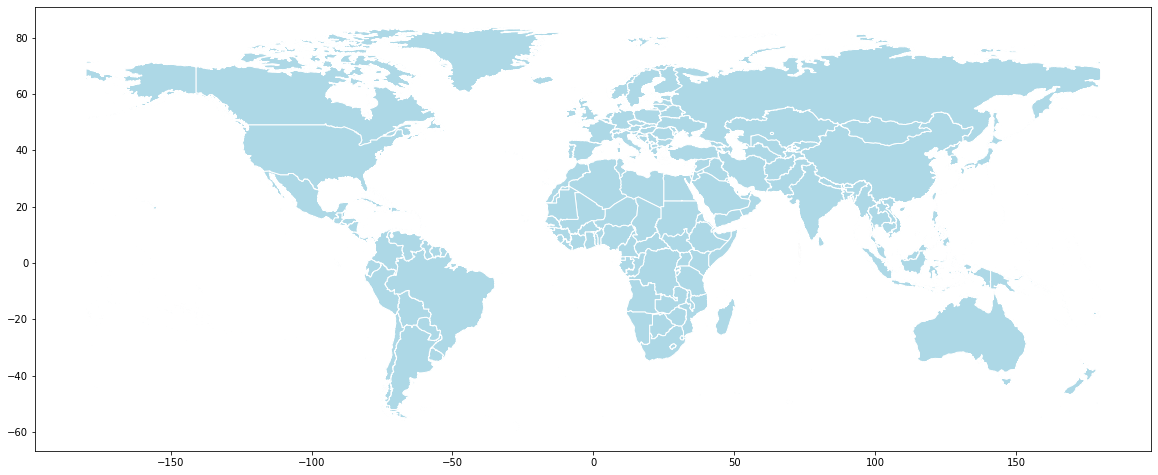

In [15]:
import geopandas as gpd

# Setting the path to the shapefile
# shapefile = 'ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp'

# Read shapefile using Geopandas
# geo_df = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
geo_df = gpd.read_file('countries.geojson')

# geo_df['geometry'][geo_df['ADMIN'] == 'France'] = geo2_df['geometry'][geo2_df['ADMIN'] == 'France']
def replace_iso2(alpha):
    try:
        return pc.countries.get(alpha_3=alpha).alpha_2
    except:
        return alpha
    
geo_df['iso2_code']= (np.array(list(map(lambda x: replace_iso2(x), geo_df['ISO_A3']))))

# Rename columns
geo_df.columns = ['country', 'country_code', 'geometry', 'iso2_code']

# Drop row for 'Antarctica'. It takes a lot of space in the map and is not of much use
geo_df = geo_df.drop(geo_df.loc[geo_df['country'] == 'Antarctica'].index)

# Print the map
geo_df.plot(figsize=(20, 20), edgecolor='white', linewidth=1, color='lightblue')

C:\Users\tomma\AppData\Local\Temp/ipykernel_9308/1658688595.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_df['iso2_code'][geo_df['country'] == 'United Kingdom'] = 'UK'
C:\Users\tomma\AppData\Local\Temp/ipykernel_9308/1658688595.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_df['iso2_code'][geo_df['country'] == 'Greece'] = 'EL'
C:\Users\tomma\AppData\Local\Temp/ipykernel_9308/1658688595.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

(-198.0, 198.0000000000002, -62.87025556054979, 90.06827386555008)

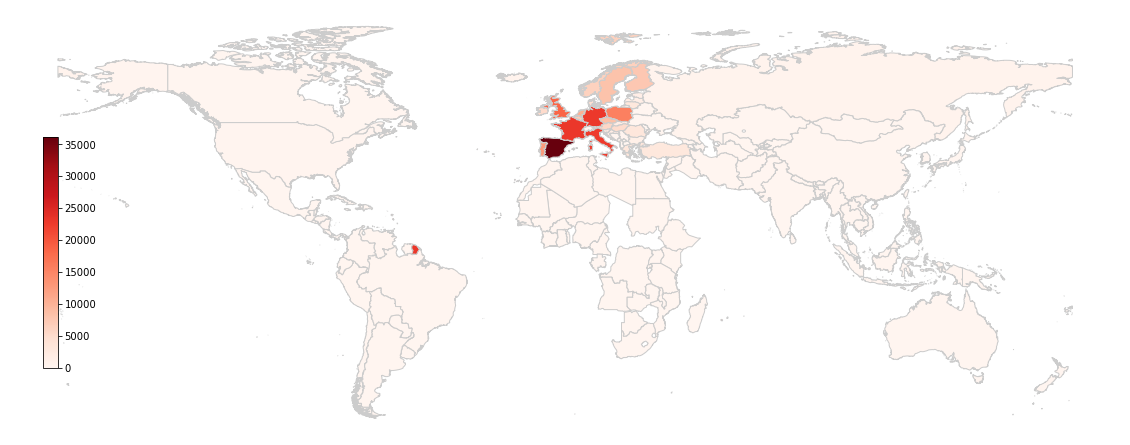

In [16]:
# import country_converter as coco

fig, ax = plt.subplots(1, figsize=(20, 8))

# adding code country to scores dataframe
countries_codes = nodes_df
countries_codes['code'] = nodes
scores_merge = pd.merge(left=countries_codes, right=scores, how='right', left_on='Nodes', right_on='Nodes')

# geo_df contains iso3 codes so we need to convert them to iso2
# geo_df['iso2_code'] = coco.convert(names=list(geo_df['country']), to='ISO2', not_found='NULL')
# geo_df = geo_df.drop(geo_df.loc[geo_df['iso2_code'] == 'NULL'].index)

# in geo_df United Kingdom has code GB, so we have to change it manually
geo_df['iso2_code'][geo_df['country'] == 'United Kingdom'] = 'UK'
geo_df['iso2_code'][geo_df['country'] == 'Greece'] = 'EL'
geo_df['iso2_code'][geo_df['country'] == 'Kosovo'] = 'XK'
geo_df['country'][geo_df['country'] == 'Czech Republic'] = 'Czechia'
geo_df['country'][geo_df['country'] == 'Republic of Serbia'] = 'Serbia'

# adding Switzerland since there is no Erasmus data
sw = {'Nodes':'Switzerland', 'code':'CH', 'in degree':0, 'out degree':0, 'hits hub':0, 'hits autority':0,
       'PageRank hub':0, 'PageRank authority':0, 'in degree position':0,
       'out degree position':0, 'hits hub position':0, 'hits autority position':0,
       'PageRank hub position':0, 'PageRank authority position':0}
scores_merge = scores_merge.append(sw, ignore_index = True)

merged_df = pd.merge(left=geo_df, right=scores_merge, how='right', left_on='iso2_code', right_on='code')
merged_df.dropna(subset=['Nodes'], inplace=True)
merged_df.plot(column='in degree', ax=ax, edgecolor='0.8', linewidth=1, cmap='Reds')

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=merged_df['in degree'].min(), 
                                              vmax=merged_df['in degree'].max()), cmap='Reds')

# Empty array for the data range
sm._A = []

# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
ax.axis('off')

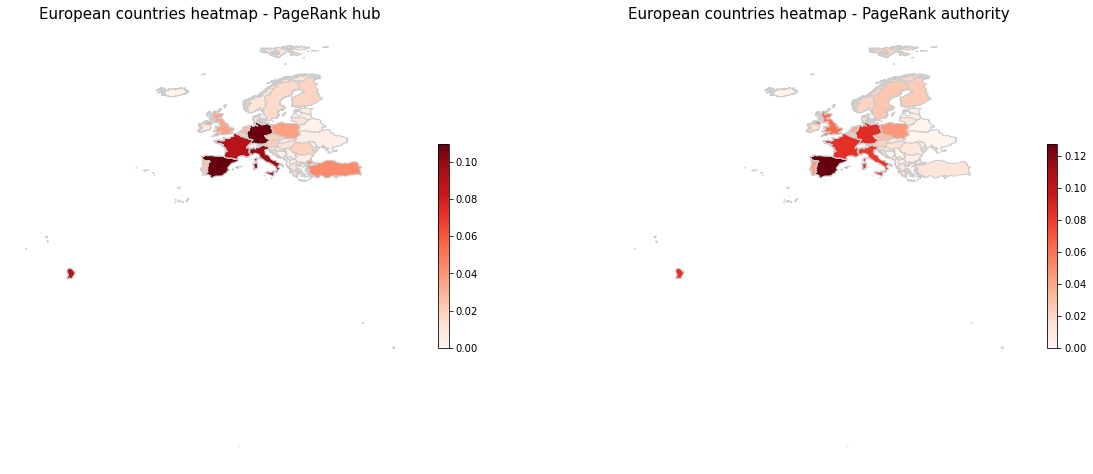

In [17]:
european_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']
# Russia has not been taken in consideration since it was too big to show and has very low exchanges

european_df = merged_df[merged_df['country'].isin(european_countries)]

# deg_list = ['in degree', 'out degree', 'PageRank hub', 'PageRank autority']
#fig4, ax4 = plt.subplots(1,4, figsize=(20,15))
plt_list = ['PageRank hub', 'PageRank authority']
fig4, ax4 = plt.subplots(1,2, figsize=(20,15))

for i in range(len(plt_list)):
    european_df.plot(column=plt_list[i], ax=ax4[i], edgecolor='0.8', linewidth=1, cmap='Reds')
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df[plt_list[i]].min(), 
                                              vmax=european_df[plt_list[i]].max()), cmap='Reds')
    ax4[i].axis('off')
    fig4.colorbar(sm, ax=ax4[i], shrink=0.25)
    ax4[i].set_title('European countries heatmap - ' + plt_list[i], fontsize=15)

# ax4 = np.reshape(ax4, (2,2))
plt.savefig('eu_pagerank.png')

GeoPlot for Communities

C:\Users\tomma\AppData\Local\Temp/ipykernel_9308/1988393302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_comm['Nodes'][node_comm['Nodes'] == 'Moldova, Republic of'] = 'Moldova'
C:\Users\tomma\AppData\Local\Temp/ipykernel_9308/1988393302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_comm['Nodes'][node_comm['Nodes'] == 'North Macedonia'] = 'Macedonia'
C:\Users\tomma\AppData\Local\Temp/ipykernel_9308/1988393302.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

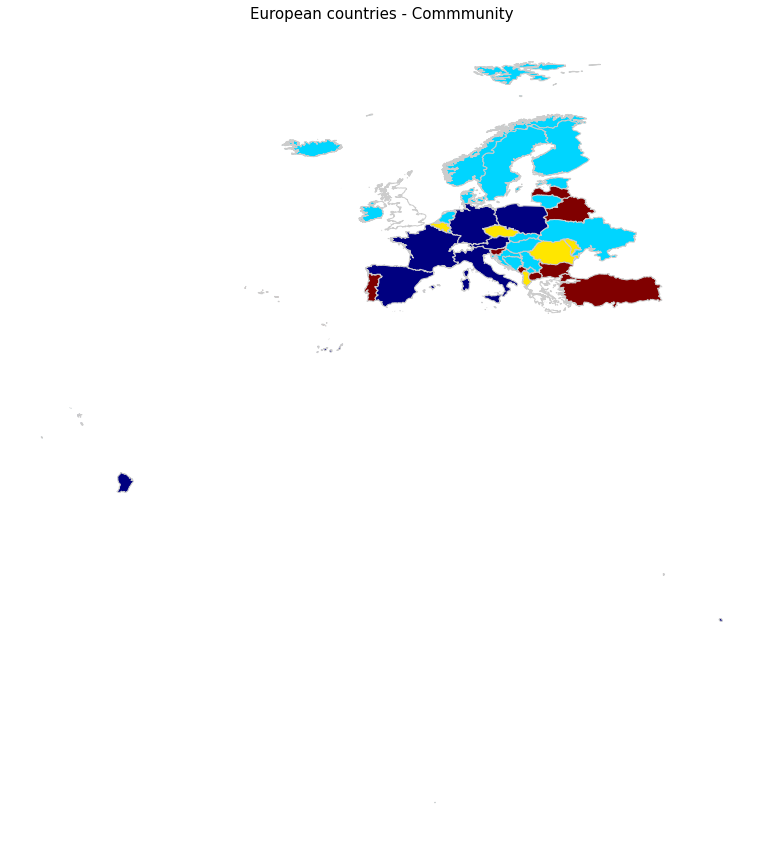

In [18]:
node_comm['Nodes'][node_comm['Nodes'] == 'Moldova, Republic of'] = 'Moldova'
node_comm['Nodes'][node_comm['Nodes'] == 'North Macedonia'] = 'Macedonia'
node_comm['Nodes'][node_comm['Nodes'] == 'XK'] = 'Kosovo'

eu_communities = european_df.copy()
eu_communities['Community'] = node_comm[node_comm['Nodes'].isin(european_countries)]['Community']

fig5, ax5 = plt.subplots(figsize=(20,15))
eu_communities.plot(column='Community', ax=ax5, edgecolor='0.8', linewidth=1, cmap='jet')
ax5.axis('off')
ax5.set_title('European countries - Commmunity', fontsize=15)

plt.savefig('eu_community.png')

## Erasmus exchanges vs total students enrolled per country

In [19]:
# https://www.eter-project.com/#/search

# dataset containing for each european university the students enrolled in ISCED 5-7 (tertiary education and master degree)
isced57_df = pd.read_csv("eter-export-2016.csv", delimiter=';', on_bad_lines='skip')
isced57_df.dropna(inplace=True)
for index in range(len(isced57_df['Institution Name'])):
    if isced57_df.iat[index,0] != isced57_df.iat[index,0].upper():
        isced57_df.iat[index,0] = isced57_df.iat[index,0].upper()
        
# dropping all the values that (inexplicably) have to too many numbers after comma
mask = isced57_df['Total students enrolled ISCED 5-7'].str.contains(',', na=False)
isced57_df = isced57_df[~mask]

# dropping rows with undefined values
isced57_df = isced57_df[~isced57_df['Total students enrolled ISCED 5-7'].isin(['m','a','c','xr','s'])]

# changing country codes accordingly to european_df ones
isced57_df['Country Code'][isced57_df['Country Code'] == 'GR'] = 'EL'

isced57_df['Total students enrolled ISCED 5-7'] = isced57_df['Total students enrolled ISCED 5-7'].astype(float)
isced57_df['Total students enrolled ISCED 5-7'] = isced57_df['Total students enrolled ISCED 5-7'].round()
# count total number of enrolled students for each country
isced57_df = isced57_df.groupby(['Country Code'])['Total students enrolled ISCED 5-7'].sum().reset_index()

european_df_w = pd.merge(left=isced57_df, right=european_df, how='right', left_on='Country Code', right_on='iso2_code')
# merged_df.dropna(inplace=True)
european_df_w = gpd.GeoDataFrame(european_df_w, geometry = 'geometry')
european_df_w

,Country Code,Total students enrolled ISCED 5-7,country,country_code,geometry,iso2_code,Nodes,code,in degree,out degree,hits hub,hits autority,PageRank hub,PageRank authority,in degree position,out degree position,hits hub position,hits autority position,PageRank hub position,PageRank authority position
0,NaN,NaN,Montenegro,MNE,"POLYGON ((19.05499 43.50670, 19.07639 43.50724...",ME,Montenegro,ME,22,96,0.000338,0.000042,0.001711,0.001122,55,59,62,62,58,60
1,HR,160341.0,Croatia,HRV,"MULTIPOLYGON (((16.93393 42.77094, 16.93637 42...",HR,Croatia,HR,1913,1436,0.005143,0.006149,0.005785,0.007502,23,23,23,25,24,23
2,IE,201007.0,Ireland,IRL,"MULTIPOLYGON (((-9.82409 51.63890, -9.81697 51...",IE,Ireland,IE,5185,2736,0.013232,0.025929,0.009817,0.017199,15,19,16,14,21,15
3,CZ,296614.0,Czechia,CZE,"POLYGON ((14.39781 51.01311, 14.42582 51.02094...",CZ,Czechia,CZ,8353,5526,0.019231,0.027589,0.020048,0.031233,9,11,11,13,12,9
4,PT,323467.0,Portugal,PRT,"MULTIPOLYGON (((-16.02310 30.03229, -16.02302 ...",PT,Portugal,PT,12579,6864,0.025891,0.050619,0.023102,0.043197,7,9,10,7,9,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,LT,114424.0,Lithuania,LTU,"MULTIPOLYGON (((20.98894 55.29133, 20.98943 55...",LT,Lithuania,LT,2826,2200,0.007052,0.011217,0.011530,0.009983,21,22,22,19,18,21
37,SI,52535.0,Slovenia,SVN,"POLYGON ((16.34343 46.71418, 16.35728 46.71583...",SI,Slovenia,SI,2347,1422,0.004709,0.007580,0.005395,0.009222,22,24,24,22,26,22
38,UK,2263020.0,United Kingdom,GBR,"MULTIPOLYGON (((-6.28751 49.91401, -6.29727 49...",UK,UK,UK,18489,9398,0.046543,0.085194,0.036291,0.062429,5,8,5,4,7,5
39,BG,232079.0,Bulgaria,BGR,"POLYGON ((22.91956 43.83422, 23.05255 43.84282...",BG,Bulgaria,BG,1135,1085,0.003822,0.003670,0.006278,0.005220,27,26,26,27,23,27


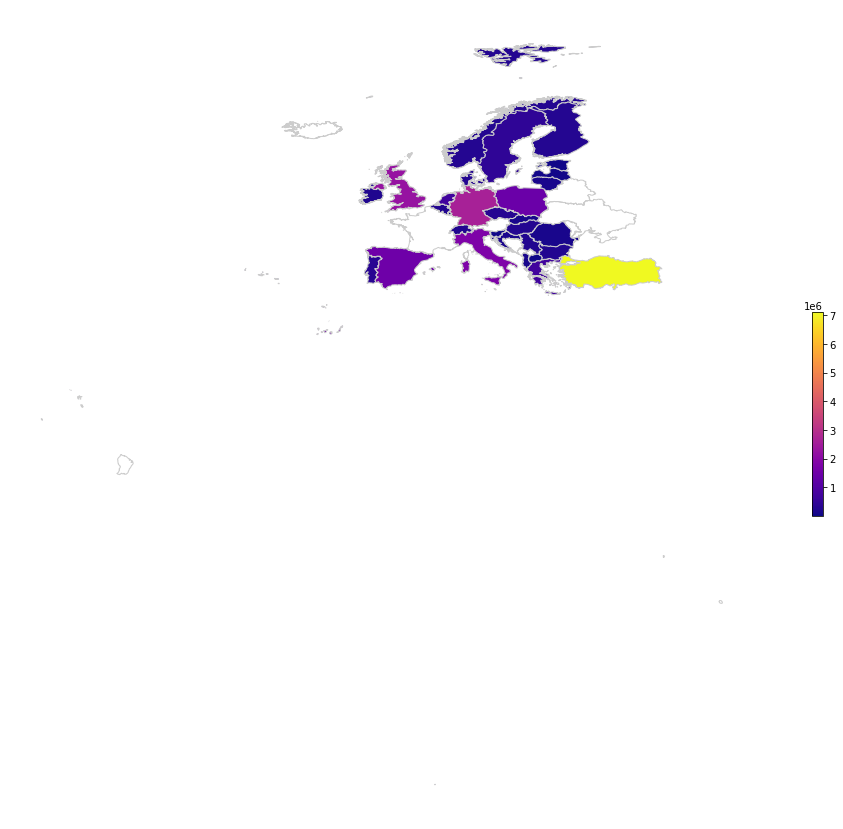

In [20]:
fig6, ax6 = plt.subplots(figsize=(20,15))
european_df_w.plot(column='Total students enrolled ISCED 5-7', ax=ax6, edgecolor='0.8', linewidth=1, cmap='plasma')
ax6.axis('off')
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df_w['Total students enrolled ISCED 5-7'].min(), 
                                              vmax=european_df_w['Total students enrolled ISCED 5-7'].max()), cmap='plasma')
fig6.colorbar(sm, ax=ax6, shrink=0.25)

C:\Users\tomma\AppData\Local\Temp/ipykernel_9308/237309935.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  european_df_w['weight_pr_hub'][european_df_w['weight_pr_hub'] > 2*10**(-7)] = 2*10**(-7)
C:\Users\tomma\AppData\Local\Temp/ipykernel_9308/237309935.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  european_df_w['weight_pr_aut'][european_df_w['weight_pr_aut'] > 2*10**(-7)] = 2*10**(-7)


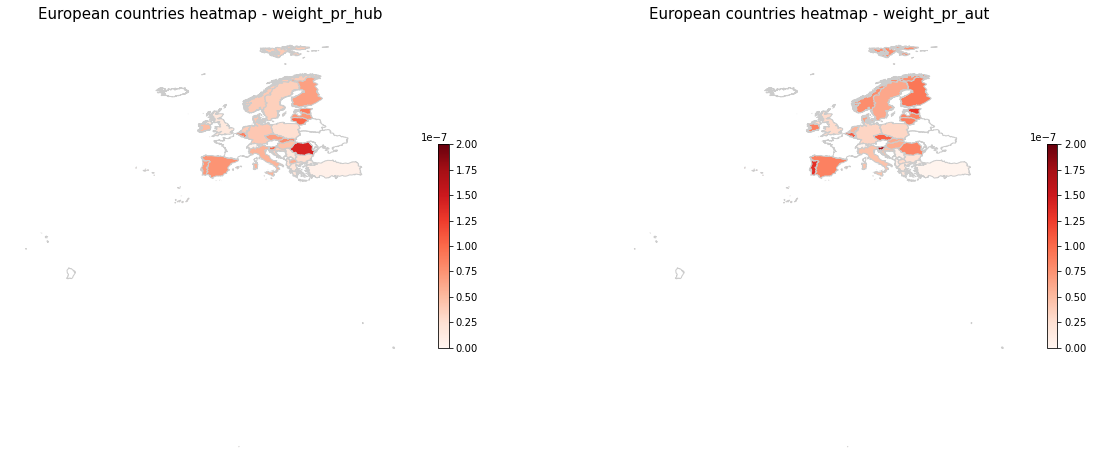

In [21]:
european_df_w['weight_pr_hub'] = european_df_w['PageRank hub']/european_df_w['Total students enrolled ISCED 5-7']
european_df_w['weight_pr_aut'] = european_df_w['PageRank authority']/european_df_w['Total students enrolled ISCED 5-7']
fig7, ax7 = plt.subplots(1,2, figsize=(20,15))

# threshold set because some countries had too big values wrt the average
european_df_w['weight_pr_hub'][european_df_w['weight_pr_hub'] > 2*10**(-7)] = 2*10**(-7)
european_df_w['weight_pr_aut'][european_df_w['weight_pr_aut'] > 2*10**(-7)] = 2*10**(-7)
# maybe set better this thresholds 

plt_list = ['weight_pr_hub', 'weight_pr_aut']
for i in range(len(plt_list)):
    # european_df_w.drop(european_df_w[plt_list[i]].idxmax(), inplace=True)
    european_df_w.plot(column=plt_list[i], ax=ax7[i], edgecolor='0.8', linewidth=1, cmap='Reds')
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df_w[plt_list[i]].min(), 
                                              vmax=european_df_w[plt_list[i]].max()), cmap='Reds')
    ax7[i].axis('off')
    fig7.colorbar(sm, ax=ax7[i], shrink=0.25)
    ax7[i].set_title('European countries heatmap - ' + plt_list[i], fontsize=15)
    
plt.savefig('eu_pagerank_weight.png')